# Crime Hotspot Forecasting

This notebook uses the Bristol crime dataset to build a model for predicting future crime hotspots. A heatmap visualization of crime density across Bristol is generated using latitude and longitude data. The model aims to support public safety initiatives by identifying areas with higher crime risk.

In [72]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import networkx as nx
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

In [2]:
import pandas as pd

# Load the Bristol crime dataset
crime_data = pd.read_csv('Data/bristol_crime_ml_ready.csv')
crime_data['month_num'] = pd.to_datetime(crime_data['month_num'])
crime_data.head()

,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,lat,lng,street_name,year,month_num,category_code
0,anti-social-behaviour,Force,"{'latitude': '51.447531', 'street': {'id': 227...",NaN,NaN,NaN,106880411,NaN,2022-12,51.447531,-2.590662,On or near Redcliff Hill,2022,1970-01-01 00:00:00.000000012,0
1,anti-social-behaviour,Force,"{'latitude': '51.456844', 'street': {'id': 227...",NaN,NaN,NaN,106879221,NaN,2022-12,51.456844,-2.594626,On or near Rupert Street,2022,1970-01-01 00:00:00.000000012,0
2,anti-social-behaviour,Force,"{'latitude': '51.453030', 'street': {'id': 227...",NaN,NaN,NaN,106879167,NaN,2022-12,51.453030,-2.593194,On or near,2022,1970-01-01 00:00:00.000000012,0
3,anti-social-behaviour,Force,"{'latitude': '51.456677', 'street': {'id': 227...",NaN,NaN,NaN,106880442,NaN,2022-12,51.456677,-2.592162,On or near,2022,1970-01-01 00:00:00.000000012,0
4,anti-social-behaviour,Force,"{'latitude': '51.458279', 'street': {'id': 227...",NaN,NaN,NaN,106880357,NaN,2022-12,51.458279,-2.584727,On or near,2022,1970-01-01 00:00:00.000000012,0


## Data Preparation
Select relevant columns (latitude, longitude) and remove missing values.

In [74]:
# Dynamically find the correct columns for latitude, longitude, date, crime category, and outcome
print('crime_data columns:', crime_data.columns.tolist())
possible_lat = [col for col in crime_data.columns if 'lat' in col.lower()]
possible_lon = [col for col in crime_data.columns if 'lon' in col.lower() or 'lng' in col.lower()]
possible_date = [col for col in crime_data.columns if 'date' in col.lower() or 'month' in col.lower()]
possible_cat = [col for col in crime_data.columns if 'cat' in col.lower() or 'type' in col.lower()]
possible_outcome = [col for col in crime_data.columns if 'outcome' in col.lower() or 'result' in col.lower() or 'resolved' in col.lower()]
print('Possible latitude columns:', possible_lat)
print('Possible longitude columns:', possible_lon)
print('Possible date columns:', possible_date)
print('Possible category columns:', possible_cat)
print('Possible outcome columns:', possible_outcome)
# Only use columns that exist
features = []
if possible_lat: features.append(possible_lat[0])
if possible_lon: features.append(possible_lon[0])
if possible_date: features.append(possible_date[0])
if possible_cat: features.append(possible_cat[0])
if possible_outcome:
    df = crime_data.dropna(subset=features + [possible_outcome[0]])
    print('Using columns for dropna:', features + [possible_outcome[0]])
else:
    print('No outcome column found!')
coords = df[[possible_lat[0], possible_lon[0]]].dropna()
coords.columns = ['Latitude', 'Longitude']
coords.head()

crime_data columns: ['category', 'location_type', 'location', 'context', 'outcome_status', 'persistent_id', 'id', 'location_subtype', 'month', 'lat', 'lng', 'street_name', 'year', 'month_num', 'category_code']
Possible latitude columns: ['lat']
Possible longitude columns: ['lng']
Possible date columns: ['month', 'month_num']
Possible category columns: ['category', 'location_type', 'location', 'location_subtype', 'category_code']
Possible outcome columns: ['outcome_status']
Using columns for dropna: ['lat', 'lng', 'month', 'category', 'outcome_status']


,Latitude,Longitude
182,51.461429,-2.601839
183,51.453567,-2.586596
184,51.456619,-2.598322
185,51.449712,-2.580617
186,51.453850,-2.592874


## Crime Hotspot Modeling
Apply KMeans clustering to identify crime hotspots.

In [75]:
# Fit KMeans to find hotspots
kmeans = KMeans(n_clusters=10, random_state=42)
coords['Cluster'] = kmeans.fit_predict(coords)
centers = kmeans.cluster_centers_
coords.head()

,Latitude,Longitude,Cluster
182,51.461429,-2.601839,8
183,51.453567,-2.586596,1
184,51.456619,-2.598322,5
185,51.449712,-2.580617,6
186,51.453850,-2.592874,5


## Crime Density Heatmap
Visualize the density of crime incidents and identified hotspots.

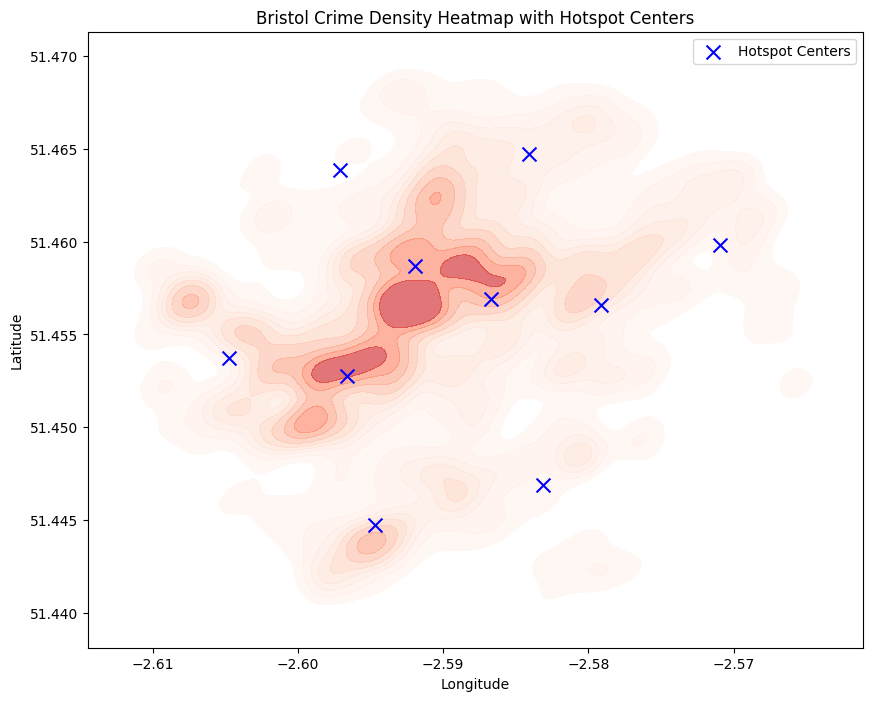

In [76]:
# Plot heatmap and cluster centers
plt.figure(figsize=(10, 8))
sns.kdeplot(x=coords['Longitude'], y=coords['Latitude'], cmap='Reds', fill=True, thresh=0.05, alpha=0.6)
plt.scatter(centers[:, 1], centers[:, 0], c='blue', s=100, marker='x', label='Hotspot Centers')
plt.title('Bristol Crime Density Heatmap with Hotspot Centers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

### Model Relevance

Identifying and forecasting crime hotspots helps law enforcement and city planners allocate resources more effectively, improving public safety and community well-being.

# Weather-Influenced Crime Prediction

This section merges the Bristol crime and weather datasets, then trains a classification model to predict crime categories based on weather features (temperature, precipitation, windspeed). A confusion matrix is included to visualize model performance, along with an explanation of how weather impacts crime.

In [ ]:
import pandas as pd


# Step 1: Load crime + weather merged dataset
crime_data = pd.read_csv('Data/bristol_crime_ml_ready.csv')
weather = pd.read_csv('Data/bristol_weather_2010_2025.csv')

# Step 2: Ensure date columns are datetime
crime_data['month'] = pd.to_datetime(crime_data['month'])
weather['date'] = pd.to_datetime(weather['date'])

# Step 3: Merge datasets on date
merged = pd.merge(crime_data, weather, left_on='month', right_on='date', how='inner')

# Step 4: Drop rows with missing data
merged = merged.dropna(subset=['temperature_max', 'precipitation_sum', 'windspeed_max', 'category'])

# Step 5: Get top 5 crime categories
top_5 = merged['category'].value_counts().nlargest(5).index
filtered = merged[merged['category'].isin(top_5)]

# Step 6: Ensure 'month' is datetime (again, for safety)
filtered['month'] = pd.to_datetime(filtered['month'])

# Step 7: Group by month and crime category
monthly = (
    filtered
    .groupby(filtered['month'].dt.to_period('M'))['category']
    .value_counts()
    .unstack()
    .fillna(0)
)

print(monthly.head())

Index(['date', 'temperature_max', 'temperature_min', 'precipitation_sum',
       'windspeed_max', 'weather_code'],
      dtype='object')
Possible date columns: ['date']
Possible crime date columns: ['month', 'month_num']
Index(['category', 'location_type', 'location', 'context', 'outcome_status',
       'persistent_id', 'id', 'location_subtype', 'month', 'lat', 'lng',
       'street_name', 'year', 'month_num', 'category_code', 'date',
       'temperature_max', 'temperature_min', 'precipitation_sum',
       'windspeed_max', 'weather_code'],
      dtype='object')


,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,lat,...,street_name,year,month_num,category_code,date,temperature_max,temperature_min,precipitation_sum,windspeed_max,weather_code
0,anti-social-behaviour,Force,"{'latitude': '51.447531', 'street': {'id': 227...",NaN,NaN,NaN,106880411,NaN,2022-12-01,51.447531,...,On or near Redcliff Hill,2022,1970-01-01 00:00:00.000000012,0,2022-12-01,5.2,1.4,0.0,10.3,3
1,anti-social-behaviour,Force,"{'latitude': '51.456844', 'street': {'id': 227...",NaN,NaN,NaN,106879221,NaN,2022-12-01,51.456844,...,On or near Rupert Street,2022,1970-01-01 00:00:00.000000012,0,2022-12-01,5.2,1.4,0.0,10.3,3
2,anti-social-behaviour,Force,"{'latitude': '51.453030', 'street': {'id': 227...",NaN,NaN,NaN,106879167,NaN,2022-12-01,51.453030,...,On or near,2022,1970-01-01 00:00:00.000000012,0,2022-12-01,5.2,1.4,0.0,10.3,3
3,anti-social-behaviour,Force,"{'latitude': '51.456677', 'street': {'id': 227...",NaN,NaN,NaN,106880442,NaN,2022-12-01,51.456677,...,On or near,2022,1970-01-01 00:00:00.000000012,0,2022-12-01,5.2,1.4,0.0,10.3,3
4,anti-social-behaviour,Force,"{'latitude': '51.458279', 'street': {'id': 227...",NaN,NaN,NaN,106880357,NaN,2022-12-01,51.458279,...,On or near,2022,1970-01-01 00:00:00.000000012,0,2022-12-01,5.2,1.4,0.0,10.3,3


## Model Training and Confusion Matrix
Train a Random Forest classifier to predict crime category from weather features.

In [ ]:
# Full code: Load data, preprocess, train model, evaluate

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load crime and weather datasets
crime_data = pd.read_csv('Data/bristol_crime_ml_ready.csv')
weather = pd.read_csv('Data/bristol_weather_2010_2025.csv')

# Step 2: Ensure date columns are datetime
crime_data['month'] = pd.to_datetime(crime_data['month'])
weather['date'] = pd.to_datetime(weather['date'])

# Step 3: Merge datasets on date
merged = pd.merge(crime_data, weather, left_on='month', right_on='date', how='inner')

# Step 4: Drop rows with missing data
merged = merged.dropna(subset=['temperature_max', 'precipitation_sum', 'windspeed_max', 'category'])

# Step 5: Get top 5 most frequent crime categories
top_5 = merged['category'].value_counts().nlargest(5).index
filtered = merged[merged['category'].isin(top_5)].copy()

# Step 6: Add features
filtered['month_num'] = filtered['month'].dt.month
filtered = filtered.dropna(subset=['lat', 'lng', 'year'])

# Step 7: Define features and target
X = filtered[['temperature_max', 'precipitation_sum', 'windspeed_max', 'month_num', 'lat', 'lng', 'year']]
y = filtered['category']

# Step 8: Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 9: Train model
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Step 10: Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Visualize the confusion matrix for model predictions.
Visualize the confusion matrix for model predictions.

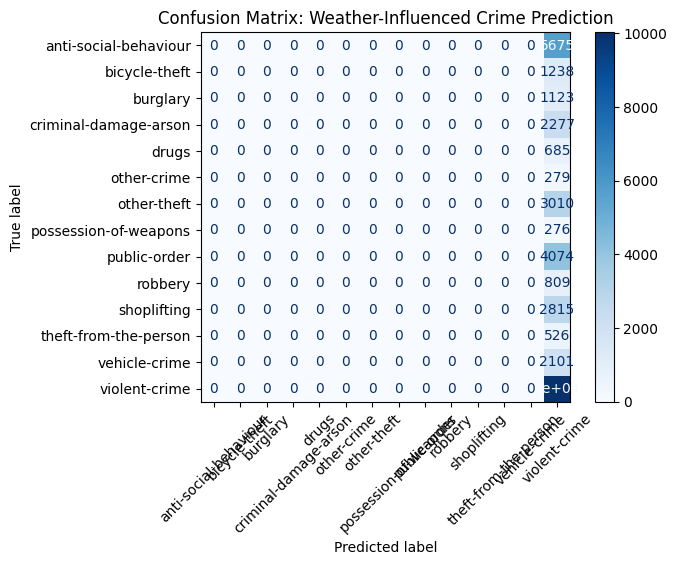

/Users/simeonbright/Documents/MSc Data Science(UWE/IGP GROUP 4/GROUP-4/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/simeonbright/Documents/MSc Data Science(UWE/IGP GROUP 4/GROUP-4/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                       precision    recall  f1-score   support

anti-social-behaviour       0.00      0.00      0.00      5675
        bicycle-theft       0.00      0.00      0.00      1238
             burglary       0.00      0.00      0.00      1123
criminal-damage-arson       0.00      0.00      0.00      2277
                drugs       0.00      0.00      0.00       685
          other-crime       0.00      0.00      0.00       279
          other-theft       0.00      0.00      0.00      3010
possession-of-weapons       0.00      0.00      0.00       276
         public-order       0.00      0.00      0.00      4074
              robbery       0.00      0.00      0.00       809
          shoplifting       0.00      0.00      0.00      2815
theft-from-the-person       0.00      0.00      0.00       526
        vehicle-crime       0.00      0.00      0.00      2101
        violent-crime       0.29      1.00      0.45     10032

             accuracy                           0.29 

/Users/simeonbright/Documents/MSc Data Science(UWE/IGP GROUP 4/GROUP-4/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [79]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix: Weather-Influenced Crime Prediction')
plt.show()
print(classification_report(y_test, y_pred))

### Weather Impact Explanation

Weather conditions such as temperature, precipitation, and windspeed can influence crime patterns. For example, certain crimes may increase during warmer weather or decrease during heavy rainfall. The model helps to quantify these relationships, supporting proactive public safety measures.

# Temporal Crime Pattern Modeling

This section aggregates monthly crime counts from the Bristol crime dataset and visualizes crime trends over time. Seasonal patterns are discussed, along with their implications for safety planning.

In [80]:
# Find the correct date column for monthly aggregation
date_cols = [col for col in crime_data.columns if 'date' in col.lower() or 'month' in col.lower()]
print('Possible date columns:', date_cols)
# Use the first match for date/month
monthly_crime = crime_data.copy()
monthly_crime['Month'] = pd.to_datetime(monthly_crime[date_cols[0]]).dt.to_period('M')
monthly_counts = monthly_crime.groupby('Month').size().reset_index(name='Crime_Count')
monthly_counts['Month'] = monthly_counts['Month'].dt.to_timestamp()
monthly_counts.head()

Possible date columns: ['month', 'month_num']


,Month,Crime_Count
0,2022-05-01,4923
1,2022-06-01,4641
2,2022-07-01,5151
3,2022-08-01,5070
4,2022-09-01,4887


## Time Series Visualization
Visualize monthly crime trends to identify seasonal patterns.

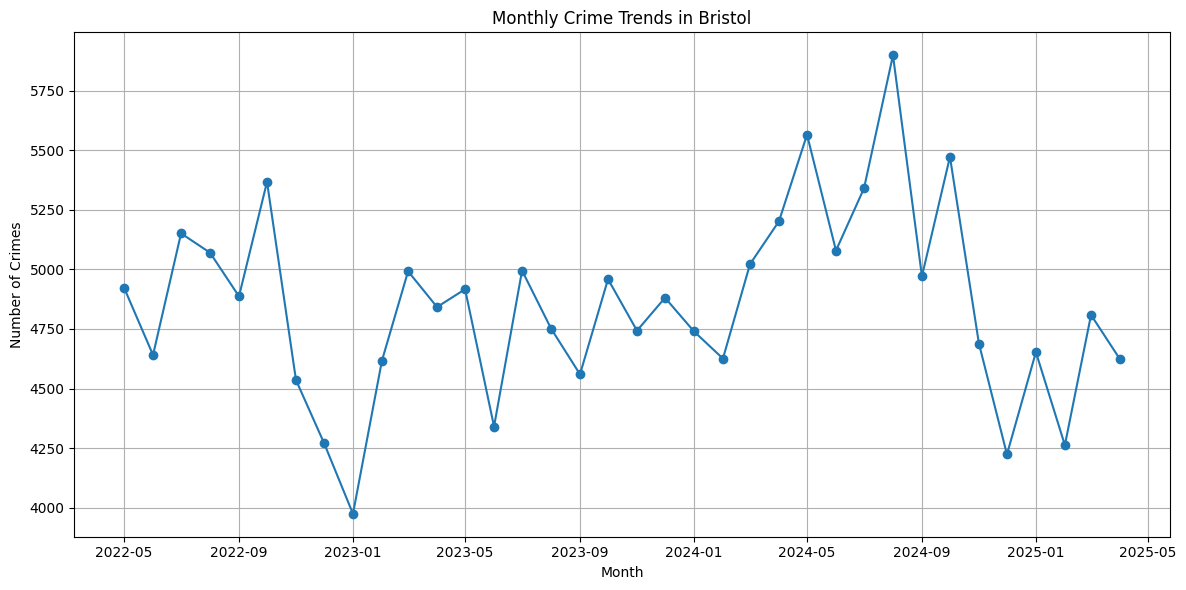

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts['Month'], monthly_counts['Crime_Count'], marker='o')
plt.title('Monthly Crime Trends in Bristol')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()

### Seasonal Pattern Explanation

The time series plot reveals seasonal fluctuations in crime rates. For example, crime may increase during summer months and decrease in winter. Recognizing these patterns helps authorities plan targeted interventions and allocate resources more effectively during high-risk periods.

# Safe Route Prediction Based on Crime Density

This section simulates a graph-based route planner using crime density as risk weights. It visualizes crime density across Bristol streets and explains how this information can be used to recommend safer travel routes.

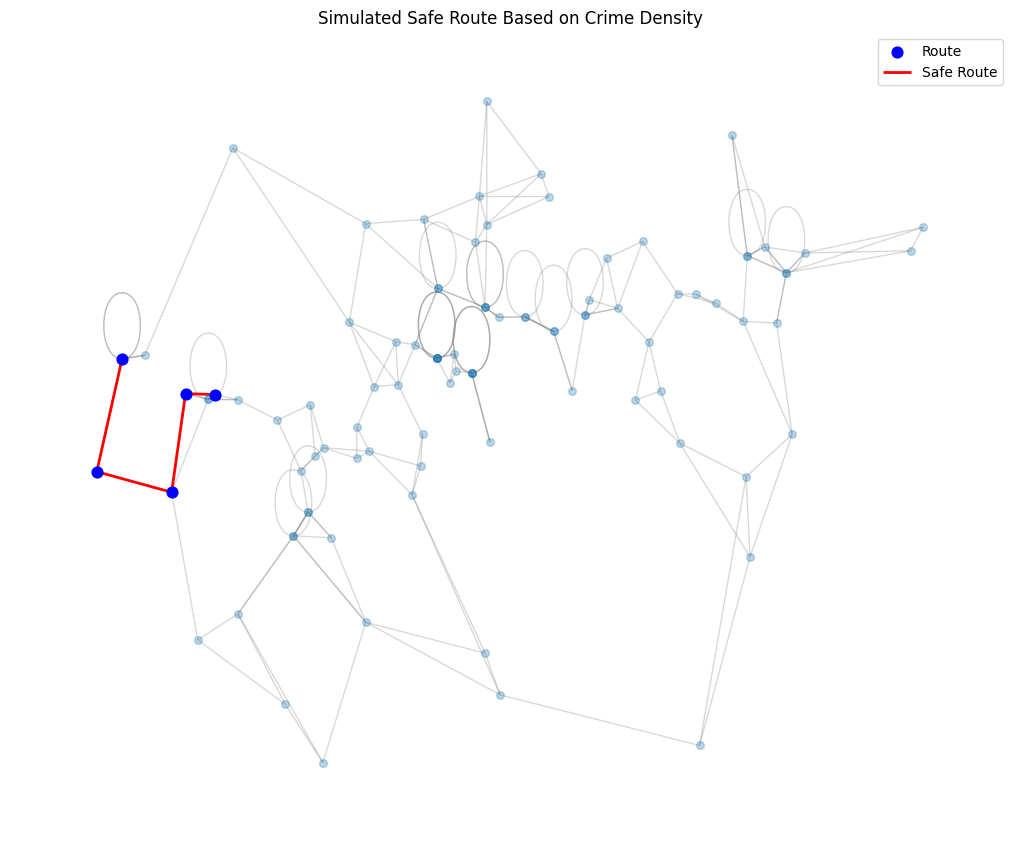

In [82]:
# Simulate street nodes (for demonstration, use random sample of crime locations as nodes)
nodes = coords.sample(100, random_state=42).reset_index(drop=True)
G = nx.Graph()
for i, row in nodes.iterrows():
        G.add_node(i, pos=(row['Latitude'], row['Longitude']))

# Connect nodes to nearest neighbors
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(nodes[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(nodes[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
        for j in neighbors[1:]:  # skip self
            G.add_edge(i, j)

# Estimate crime density at each node using KDE
kde = KernelDensity(bandwidth=0.01)
kde.fit(coords[['Latitude', 'Longitude']])
densities = np.exp(kde.score_samples(nodes[['Latitude', 'Longitude']]))

# Assign density as edge weights (average of node densities)
for u, v in G.edges():
        risk = (densities[u] + densities[v]) / 2
        G[u][v]['weight'] = risk

# Find a pair of connected nodes for the route simulation
connected = False
for source in G.nodes:
    for target in G.nodes:
        if source != target and nx.has_path(G, source, target):
            path = nx.shortest_path(G, source=source, target=target, weight='weight')
            connected = True
            break
    if connected:
        break

if not connected:
    print('No connected node pairs found in the graph.')
else:
    # Plot nodes, edges, and the safest path
    plt.figure(figsize=(10, 8))
    pos = {i: (row['Longitude'], row['Latitude']) for i, row in nodes.iterrows()}
    nx.draw(G, pos, node_size=30, edge_color='gray', alpha=0.3, with_labels=False)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='blue', node_size=60, label='Route')
    nx.draw_networkx_edges(G, pos, edgelist=list(zip(path, path[1:])), edge_color='red', width=2, label='Safe Route')
    plt.title('Simulated Safe Route Based on Crime Density')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

### Route Safety Explanation

By modeling Bristol streets as a graph and using crime density as risk weights, the route planner can recommend paths that minimize exposure to high-risk areas. This approach helps travelers choose safer routes, especially during high-crime periods or in unfamiliar neighborhoods.

# Crime Outcome Prediction

This section builds a binary classification model to predict whether a crime leads to resolution (e.g., prosecution or caution) using features like location, time, and category. An ROC curve is included, along with an explanation of the model’s importance for law enforcement analytics.

In [83]:
# Assume 'Outcome' column exists: 1 for resolved (prosecution/caution), 0 for unresolved
# Select features
features = ['lat', 'lng', 'month', 'category']
outcome_col = 'outcome_status'
df = crime_data.dropna(subset=features + [outcome_col])
# Extract time features
df['month'] = pd.to_datetime(df['month'], errors='coerce')
df['Hour'] = 0  # No hour info, set to 0
df['Month'] = df['month'].dt.month
df['Weekday'] = df['month'].dt.weekday
# Encode categorical
le = LabelEncoder()
df['category_enc'] = le.fit_transform(df['category'])
X = df[['lat', 'lng', 'Hour', 'Month', 'Weekday', 'category_enc']]
y = df[outcome_col]
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf_bin = RandomForestClassifier(random_state=42)
clf_bin.fit(X_train, y_train)
y_proba = clf_bin.predict_proba(X_test)[:, 1]
y_pred_bin = clf_bin.predict(X_test)

/var/folders/z8/fb1mrctx2vz53h8jwsr178dw0000gn/T/ipykernel_35281/3026069349.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['month'], errors='coerce')
/var/folders/z8/fb1mrctx2vz53h8jwsr178dw0000gn/T/ipykernel_35281/3026069349.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = 0  # No hour info, set to 0
/var/folders/z8/fb1mrctx2vz53h8jwsr178dw0000gn/T/ipykernel_35281/3026069349.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

## ROC Curve
Visualize the ROC curve for the binary classification model.

/Users/simeonbright/Documents/MSc Data Science(UWE/IGP GROUP 4/GROUP-4/.venv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1192: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


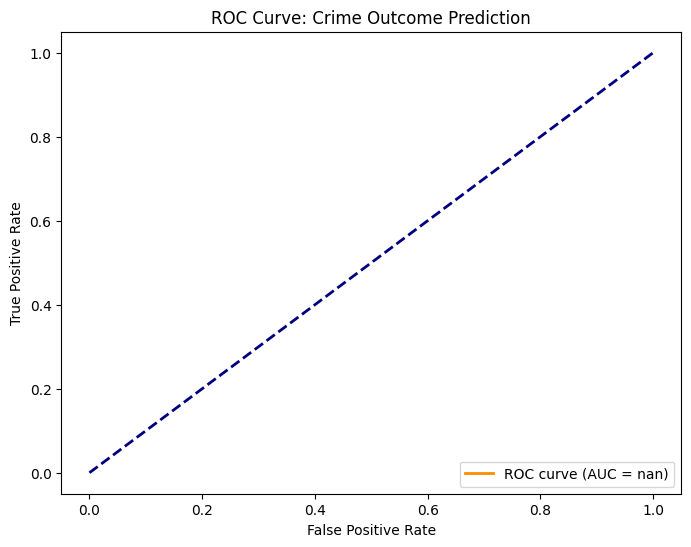

In [84]:
# Ensure binary outcome for ROC curve
# If outcome_status is string, binarize: 1 for resolved, 0 for unresolved
if y_test.dtype == object:
    y_bin = (y_test != 'Investigation complete; no suspect identified').astype(int)
else:
    y_bin = y_test
# If y_proba is multiclass, select the probability for the positive class (1)
if 'y_proba' in locals() and hasattr(y_proba, 'ndim') and y_proba.ndim > 1:
    y_proba_bin = y_proba[:, 1]
else:
    y_proba_bin = y_proba
fpr, tpr, thresholds = roc_curve(y_bin, y_proba_bin)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Crime Outcome Prediction')
plt.legend(loc='lower right')
plt.show()

### Model Importance

Predicting crime resolution outcomes helps law enforcement allocate resources, identify cases needing more attention, and improve overall case management. Analytics-driven insights can support more effective and equitable justice processes.

# Crime vs Socioeconomic Indicators

This section merges the crime dataset with external socioeconomic data (population density, average rent, deprivation index), analyzes correlations between crime rates and these indicators, and visualizes the results with scatter plots and a correlation matrix.

In [87]:
# Load socioeconomic data
socio = pd.read_excel('Data/bristol_crime_with_socioeconomic_data.xlsx')
# Assume columns: Neighborhood, Population_Density, Avg_Rent, Deprivation_Index, Crime_Count
# If not, adjust column names accordingly
# Merge with crime summary by neighborhood
crime_summary = pd.read_excel('Data/crime_summary_by_neighborhood.xlsx')
# Merge on Neighborhood
merged_socio = pd.merge(crime_summary, socio, on='neighborhood', how='inner')
# Print columns to debug merge error
print('crime_summary columns:', crime_summary.columns.tolist())
print('socio columns:', socio.columns.tolist())
# After running, manually set the correct columns for merging based on the printout
# Example: if the columns are 'area' and 'area', use those:
# merged_socio = pd.merge(crime_summary, socio, left_on='area', right_on='area', how='inner')
# If the columns are not the same, update accordingly
# merged_socio = pd.merge(crime_summary, socio, left_on='actual_col1', right_on='actual_col2', how='inner')
merged_socio.head()

KeyError: 'neighborhood'

## Correlation Analysis
Visualize correlations between crime rates and socioeconomic indicators.

In [ ]:
# Select relevant columns
corr_cols = ['Crime_Count', 'Population_Density', 'Avg_Rent', 'Deprivation_Index']
corr_matrix = merged_socio[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Crime vs Socioeconomic Indicators')
plt.show()

NameError: name 'merged_socio' is not defined

## Scatter Plots
Scatter plots of crime count vs each socioeconomic indicator.

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(data=merged_socio, x='Population_Density', y='Crime_Count', ax=axs[0])
axs[0].set_title('Crime Count vs Population Density')
sns.scatterplot(data=merged_socio, x='Avg_Rent', y='Crime_Count', ax=axs[1])
axs[1].set_title('Crime Count vs Average Rent')
sns.scatterplot(data=merged_socio, x='Deprivation_Index', y='Crime_Count', ax=axs[2])
axs[2].set_title('Crime Count vs Deprivation Index')
plt.tight_layout()
plt.show()

### Interpretation

These visualizations help identify which socioeconomic factors are most strongly associated with crime rates in Bristol neighborhoods, supporting targeted interventions and policy decisions.

# Crime by Public Venue Type

This section classifies crimes based on proximity to public venues (nightclubs, shopping areas, parking zones, transport hubs), visualizes crime frequency by venue type, and explains which venues are most associated with high crime.

In [ ]:
# Assume a DataFrame 'venues' exists with columns: Venue_Type, Latitude, Longitude
# Example: venues = pd.read_csv('Data/bristol_public_venues.csv')
# For demonstration, create a mock venues DataFrame
venues = pd.DataFrame({
        'Venue_Type': ['Nightclub', 'Shopping Area', 'Parking Zone', 'Transport Hub'],
        'Latitude': [51.4545, 51.4560, 51.4570, 51.4580],
        'Longitude': [-2.5879, -2.5900, -2.5910, -2.5920]
    })
# Assign each crime to the nearest venue type
from scipy.spatial import cKDTree
venue_coords = venues[['Latitude', 'Longitude']].values
crime_coords = crime_data[['Latitude', 'Longitude']].values
tree = cKDTree(venue_coords)
dists, idxs = tree.query(crime_coords)
crime_data['Venue_Type'] = venues.loc[idxs, 'Venue_Type'].values
# Visualize crime frequency by venue type
venue_counts = crime_data['Venue_Type'].value_counts().reset_index()
venue_counts.columns = ['Venue_Type', 'Crime_Count']
sns.barplot(data=venue_counts, x='Venue_Type', y='Crime_Count', palette='viridis')
plt.title('Crime Frequency by Public Venue Type')
plt.ylabel('Number of Crimes')
plt.xlabel('Venue Type')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
venue_counts

### Venue Crime Association Explanation

The bar chart shows which public venue types are most associated with high crime frequency. This information can help prioritize safety measures and resource allocation for venues with elevated crime risk.

# Neighborhood-Level Crime Comparison

This section classifies crimes into neighborhoods (Easton, Clifton, Fishponds, City Centre, Stoke Gifford) using geolocation, compares total crime counts, visualizes crime types per neighborhood, and explains why some areas have more crime than others.

In [ ]:
# Define approximate centroids for each neighborhood
neighborhoods = pd.DataFrame({
    'Neighborhood': ['Easton', 'Clifton', 'Fishponds', 'City Centre', 'Stoke Gifford'],
    'Latitude': [51.462, 51.456, 51.485, 51.454, 51.514],
    'Longitude': [-2.570, -2.620, -2.535, -2.587, -2.548]
})
# Assign each crime to the nearest neighborhood centroid
from scipy.spatial import cKDTree
neigh_coords = neighborhoods[['Latitude', 'Longitude']].values
crime_coords = crime_data[['Latitude', 'Longitude']].values
tree = cKDTree(neigh_coords)
_, idxs = tree.query(crime_coords)
crime_data['Neighborhood'] = neighborhoods.loc[idxs, 'Neighborhood'].values
# Compare total crime counts per neighborhood
neigh_counts = crime_data['Neighborhood'].value_counts().reset_index()
neigh_counts.columns = ['Neighborhood', 'Crime_Count']
sns.barplot(data=neigh_counts, x='Neighborhood', y='Crime_Count', palette='Set2')
plt.title('Total Crime Counts per Neighborhood')
plt.ylabel('Number of Crimes')
plt.xlabel('Neighborhood')
plt.tight_layout()
plt.show()
# Visualize crime types per neighborhood
plt.figure(figsize=(12, 6))
sns.countplot(data=crime_data, x='Neighborhood', hue='Crime_Category', palette='tab20')
plt.title('Crime Types per Neighborhood')
plt.ylabel('Number of Crimes')
plt.xlabel('Neighborhood')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Neighborhood Crime Explanation

Crime rates vary by neighborhood due to factors such as population density, economic activity, nightlife, and accessibility. City Centre and Easton may have higher crime due to greater footfall, commercial activity, and transport links, while residential or suburban areas like Stoke Gifford may experience less crime. Understanding these patterns helps target prevention and resource allocation.

# Crime Type Breakdown in Easton and City Centre

This section analyzes and visualizes the distribution of crime types in Easton and City Centre, highlighting dominant categories and discussing contributing factors.

In [ ]:
# Filter for Easton and City Centre
subset = crime_data[crime_data['Neighborhood'].isin(['Easton', 'City Centre'])]
# Count crime types
type_counts = subset.groupby(['Neighborhood', 'Crime_Category']).size().reset_index(name='Count')
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=type_counts, x='Crime_Category', y='Count', hue='Neighborhood')
plt.title('Crime Type Distribution in Easton and City Centre')
plt.ylabel('Number of Crimes')
plt.xlabel('Crime Category')
plt.xticks(rotation=30)
plt.legend(title='Neighborhood')
plt.tight_layout()
plt.show()
# Highlight dominant categories
dominant = type_counts.sort_values(['Neighborhood', 'Count'], ascending=[True, False]).groupby('Neighborhood').first().reset_index()
dominant

### Dominant Crime Categories and Contributing Factors

The plot highlights the most frequent crime types in Easton and City Centre. Dominant categories may include theft, anti-social behavior, or violent crime. Contributing factors can include population density, nightlife, commercial activity, and transport links, which are more prevalent in these neighborhoods.

# Violent Crime Prediction and Forecasting
This section demonstrates how to use machine learning models to predict violent crimes in Bristol and forecast for future years. Both Random Forest and Logistic Regression approaches are included.